In [ ]:
import torch

In [ ]:
# Hyper parameters
sequence_length = 28 #
input_size = 28 #
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100 #
num_epochs = 10
learning_rate = 0.05

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=False,
                                        transform=transforms.ToTensor(),
                                        download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw




Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# cf) Check dataloader shape
image, label = next(iter(test_loader))
print(image.size()) # [Batch, Channel, Height, Width]


torch.Size([100, 1, 28, 28])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class RNN(nn.Module):
  def __init__(self, intput_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True , nonlinearity='tanh',dropout=0.2)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # set initial hidden states and cell states
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()# torch.size([2, 50, 128])

    #Forward propagate RNN
    out, _  = self.rnn(x, h0.detach()) # output: tensor [batch_size, seq_length, hidden_size]

    #Decode the hidden state of the last time step
    out = self.fc(out[:,-1,:])

    return out

model = RNN(input_size, hidden_size, num_layers, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [ ]:
####### Train #######
total_step = len(train_loader)
loss_list = []
for epoch in range(num_epochs):
  for i, (image, label) in enumerate(train_loader):
    image = image.reshape(-1, sequence_length, input_size)
    label = label

    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    if (i+1) % 300 == 0:
      print("Epoch [{}/{}], Step[{}/{}], Loss:{:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'modelRNN.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochsRNN.pth'.format(epoch+1))

Epoch [1/10], Step[300/600], Loss:1.1192
Epoch [1/10], Step[600/600], Loss:0.5498
Epoch [2/10], Step[300/600], Loss:0.3571
Epoch [2/10], Step[600/600], Loss:0.3195
Epoch [3/10], Step[300/600], Loss:0.2189
Epoch [3/10], Step[600/600], Loss:0.2236
Epoch [4/10], Step[300/600], Loss:0.1332
Epoch [4/10], Step[600/600], Loss:0.1611
Epoch [5/10], Step[300/600], Loss:0.2478
Epoch [5/10], Step[600/600], Loss:0.0565
Epoch [6/10], Step[300/600], Loss:0.1620
Epoch [6/10], Step[600/600], Loss:0.1886
Epoch [7/10], Step[300/600], Loss:0.1473
Epoch [7/10], Step[600/600], Loss:0.2038
Epoch [8/10], Step[300/600], Loss:0.0466
Epoch [8/10], Step[600/600], Loss:0.1050
Epoch [9/10], Step[300/600], Loss:0.0941
Epoch [9/10], Step[600/600], Loss:0.1043
Epoch [10/10], Step[300/600], Loss:0.1150
Epoch [10/10], Step[600/600], Loss:0.1430


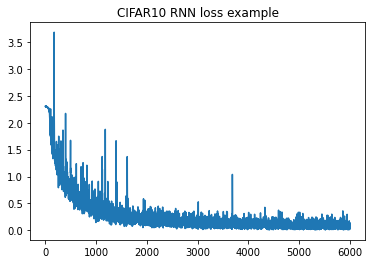

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.title("CIFAR10 RNN loss example")
plt.show()

In [ ]:
######## TEST ########

test_model = RNN(input_size, hidden_size, num_layers, num_classes)
test_model.load_state_dict(torch.load("modelRNN.pth"))

with torch.no_grad():
  correct = 0

  for image, label in test_loader:
    image = image.reshape(-1, sequence_length, input_size)
    label = label
    output = test_model(image)
    _, pred = torch.max(output.data, 1)
    correct += (pred == label).sum().item()

  print('Test Accuracy of RNN model on the {} test images: {}%'.format(len(test_data), 100 * correct / len(test_data)))

Test Accuracy of RNN model on the 10000 test images: 97.6%
